# Scan of dark Fits Files of Monocam
================================================================

- date of creation : Friday 27th 2016
- author : Sylvie Dagoret-Campagne
- affiliation : LAL/IN2P3/CNRS

In [28]:
import numpy as np

# Set up matplotlib and use a nicer set of plot parameters
#config InlineBackend.rc = {}
#config Backend.rc = {}
import matplotlib
matplotlib.rc_file("../templates/matplotlibrc")  # default config obtained from astropy examples
import matplotlib.pyplot as plt
%matplotlib inline

In [29]:
from astropy.utils.data import download_file
from astropy.io import fits
import os

In [30]:
import pandas as pd
from datetime import datetime, timedelta
from pytz import timezone
import pytz

In [31]:
path='/Users/dagoret-campagnesylvie/iraf/MonoCamMay2016/20160509'
#root_filename='bias_'
root_filename='dark_'
ext_filename='.fits'
startnum=1
#stopnum=50
stopnum=63
date=datetime(2016,5,9)  # 2016-05-10T01:07:55.503
date

datetime.datetime(2016, 5, 9, 0, 0)

In [32]:
def Buildfilename(path,name,ext,num):
    '''
    input:
       path : path of bias files
       name : common root of bias filenames
       ext  : extension of filenames
    output:
       full filename 
    '''
    strnum= '{0:02d}'.format(num)  # python >= 2.6
    filename=name+strnum+ext
    fullfilename=os.path.join(path,filename)
    return fullfilename

In [33]:
filelist= [Buildfilename(path,root_filename,ext_filename,num) for num in range(startnum,stopnum+1,1)]

In [34]:
nbfiles=len(filelist)

In [35]:
NBCHAN=16
NBFILES=nbfiles

# arrays initialisation
means0=np.zeros((NBCHAN,NBFILES),dtype=np.float)
rms0=np.zeros((NBCHAN,NBFILES),dtype=np.float)
means=np.zeros((NBCHAN,NBFILES),dtype=np.float)
rms=np.zeros((NBCHAN,NBFILES),dtype=np.float)

list_exposures=np.zeros(NBFILES,dtype=np.float)

# loop on files
for file in range(0,nbfiles):
    hdu_list = fits.open(filelist[file])
    header=hdu_list[0].header
    number_of_channels=header['CHAN']
    exposure=header['EXPOSURE']
    list_exposures[file]=exposure
    # loop on channels
    for numchan in range(1,number_of_channels+1):
        image_data = hdu_list[numchan].data
        nrow,ncol =image_data.shape
        # extract the two quatities
        firstcol = image_data[:,0]
        othercol = image_data[:,1:ncol]
        # flatten the arrays
        lowvalue = firstcol.flatten()
        highvalue = othercol.flatten()
        # extract mean and rms
        means0[numchan-1,file]=lowvalue.mean()
        rms0[numchan-1,file]=lowvalue.std()
        means[numchan-1,file]=highvalue.mean()
        rms[numchan-1,file]=highvalue.std()        
                

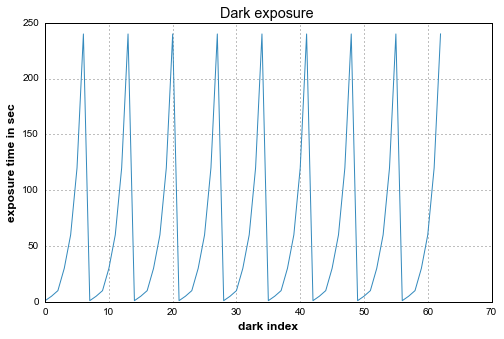

In [36]:
title='Dark exposure '
fig = plt.figure(figsize=(8,5))
plt.plot(range(NBFILES),list_exposures)    
plt.title(title)
plt.xlabel('dark index')
plt.ylabel('exposure time in sec')
plt.grid(True)

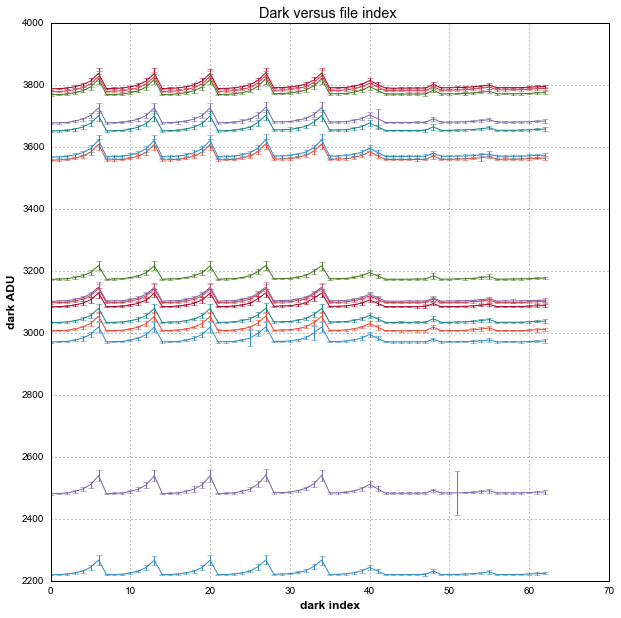

In [37]:
title='Dark versus file index '
fig = plt.figure(figsize=(10,10))
for numchan in range(0,number_of_channels):
    plt.errorbar(range(NBFILES),means[numchan,:],yerr=rms[numchan,:])
    
plt.title(title)
plt.xlabel('dark index')
plt.ylabel('dark ADU')
plt.grid(True)

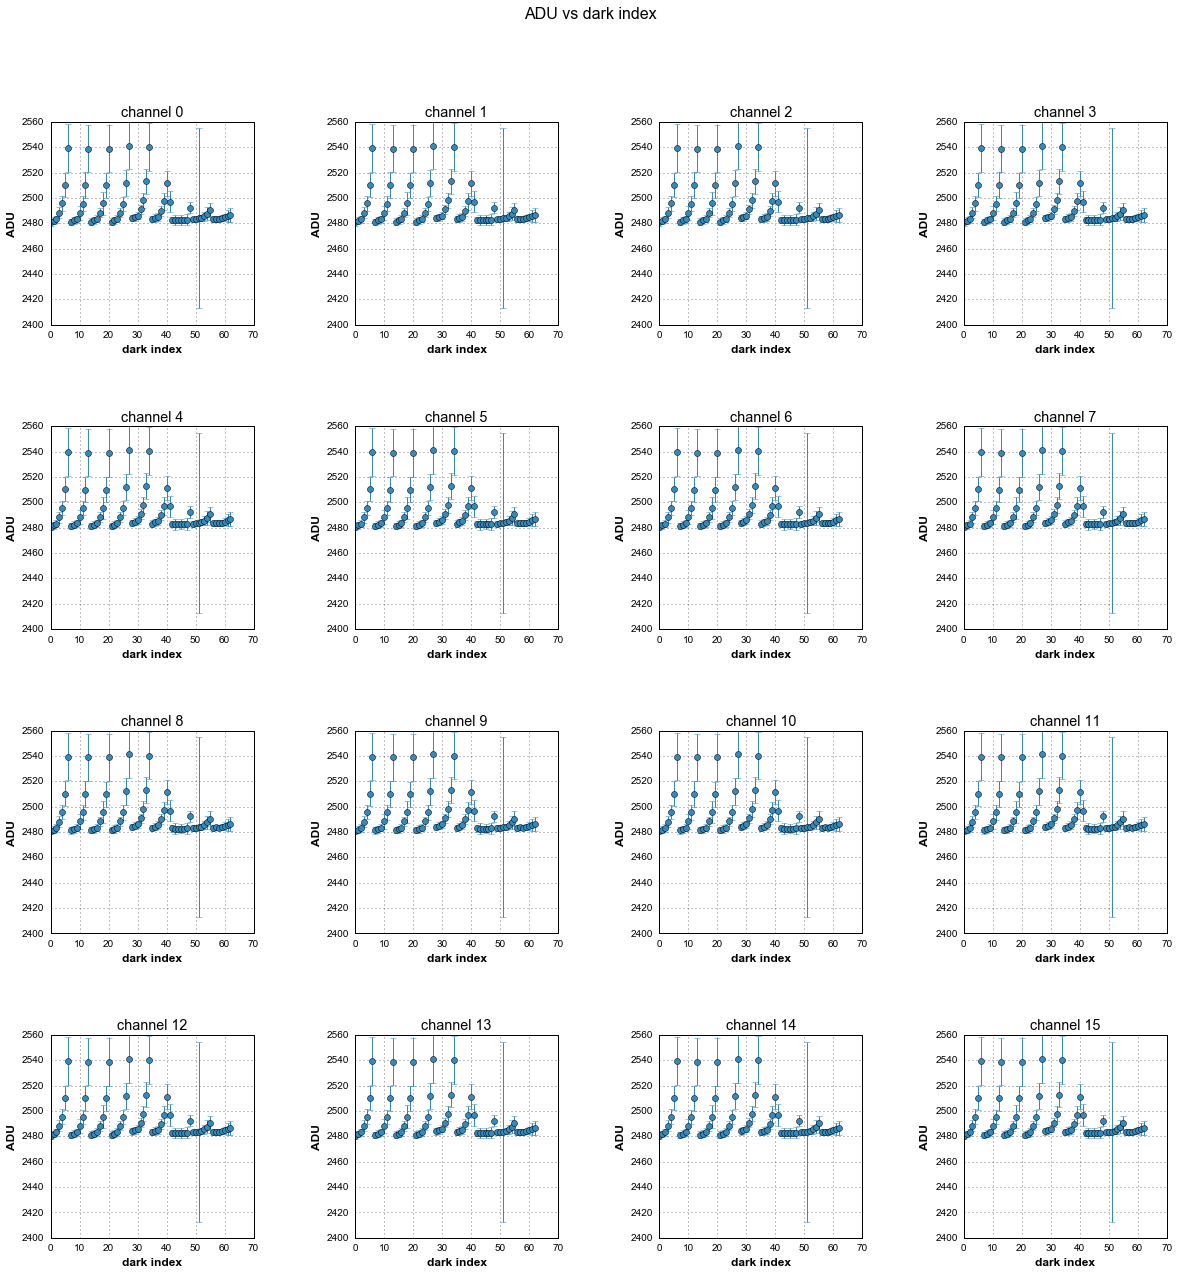

In [38]:
NX=4 # number of images along the horizontal axis
NY=4 # number of images along the vertical axis
f, axarr = plt.subplots(NY,NX,figsize=(20,20)) # figure organisation
#f, axarr = plt.subplots(NX,NY,sharex=True, sharey=True,figsize=(20,20))
f.subplots_adjust(hspace=0.5,wspace=0.5)

for index in range(0,number_of_channels):  
    ix=index%4
    iy=index/4
        
    axarr[iy,ix].errorbar(range(NBFILES),means[numchan,:],yerr=rms[numchan,:],fmt='o')
    plottitle='channel {}'.format(index)
    axarr[iy,ix].set_title(plottitle)
    axarr[iy,ix].set_ylabel('ADU')
    axarr[iy,ix].set_xlabel('dark index')
    axarr[iy,ix].grid(True)

title='ADU vs dark index'
plt.suptitle(title,size=16)
plt.show()


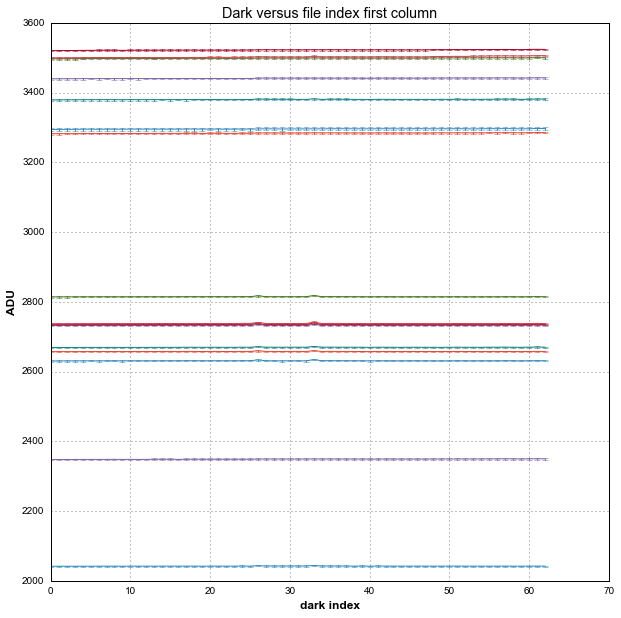

In [39]:
title='Dark versus file index first column'
fig = plt.figure(figsize=(10,10))
for numchan in range(0,number_of_channels):
    plt.errorbar(range(NBFILES),means0[numchan,:],yerr=rms0[numchan,:])
    
plt.title(title)
plt.xlabel('dark index')
plt.ylabel('ADU')
plt.grid(True)

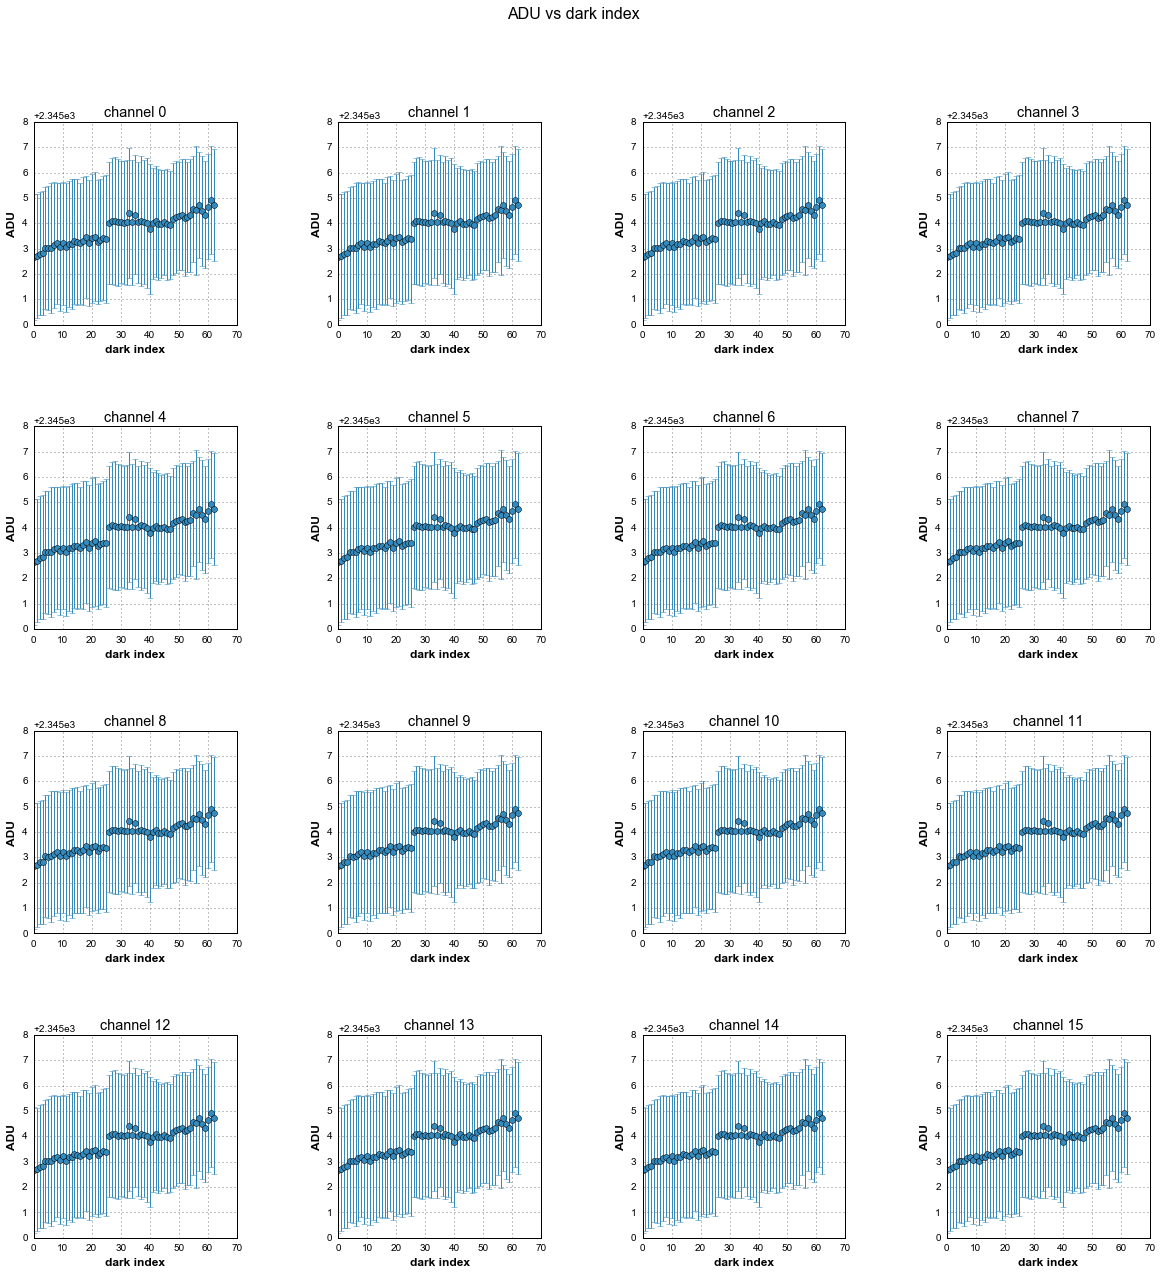

In [40]:
NX=4 # number of images along the horizontal axis
NY=4 # number of images along the vertical axis
f, axarr = plt.subplots(NY,NX,figsize=(20,20)) # figure organisation
#f, axarr = plt.subplots(NX,NY,sharex=True, sharey=True,figsize=(20,20))
f.subplots_adjust(hspace=0.5,wspace=0.5)

for index in range(0,number_of_channels):  
    ix=index%4
    iy=index/4
        
    axarr[iy,ix].errorbar(range(NBFILES),means0[numchan,:],yerr=rms0[numchan,:],fmt='o')
    plottitle='channel {}'.format(index)
    axarr[iy,ix].set_title(plottitle)
    axarr[iy,ix].set_ylabel('ADU')
    axarr[iy,ix].set_xlabel('dark index')
    axarr[iy,ix].grid(True)
    
title='ADU vs dark index'
plt.suptitle(title,size=16)
plt.show()

